# Coding Homework 2 - Neural decoding

### Preface
For plotting results of multiple runs of a simulated BCI, we will use "violin" plots in this homework. They are easy do with the `seaborn` and `pandas` packages. So if all you've installed sofar are `matplotlib` and `numpy`, please install these two more.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


### The data
The data for this lab are courtesy of the lab of the late Krishna Shenoy. These are spikes recorded from the dorsal premotor cortex (PMd) of a non-human primate engaged in a center out reaching task with an instructed delay carried out on a touch screen in front of the subject. The sample code below loads the spiking data and task metadata for each trial. For this homework assignment, we will be decoding neural activity generated in PMd during the delay period of the task (when the target is being displayed but the animal has not yet been instructed to initiate movement). We will use the timestamps associated with the start of the trial with a target onset (`time_touch_held`) and the end of the planning period for that trial, which we will approximate using the time when the go cue is shown (`time_go_cue`). In addition, in order to train the decoder and evaluate decoding performance, we need the identity of the target for each trial (`trial_reach_target`). Some other metadata are also in the file and are extracted below.

In [3]:
with open('homework2_spikes.npz', 'rb') as loadfile:
    spike_times = np.load(loadfile, allow_pickle=True)['spike_times']

with open('homework2_metadata.npy', 'rb') as loadfile:
    metadata = np.load(loadfile)
    # Note that all of these are vectors with dimensions Kx1, where K is the number of trials
    time_touch_held = metadata['time_touch_held'] # target onset times for each trial 
    time_go_cue = metadata['time_go_cue'] # go cue time for each trial
    time_target_acquired = metadata['time_target_acquired'] # time the target was touched
    trial_reach_target = metadata['trial_reach_target'] # index of reach target for each trial (0 through 7)
        # note that I've "fixed" the reach targets to be 0-7 rather than 1-8
    target_locations = metadata['target_locations'] # x,y location of each target
    target_angles = metadata['target_angles'] # angle of each target


In this dataset, to prevent anticipatory movements, the animal was randomly given trials with different delay durations! That will add a bit of complexity to how we think about implementing the decoder.

In [4]:
# Verify that there are in fact two different plan period durations
np.unique(time_go_cue - time_touch_held)

array([ 755, 1005], dtype=int64)

We'll start by providing a simple function that extracts the number of spikes from each neuron in a period of time relative to the beginning of each trial. We'll define it with two parameters - the duration of the window in which to count spikes, and an offset from the trial beginning. When called, this function will return a matrix - each column represents the activity of the neurosn for a single trial, since there are 1127 trials and 190 neurons, the matrix is 190 x 1127.

In [5]:
def extract_plan_spikes(window_length=None, 
                        start_offset=None):
    # Return a matrix of spike counts in the plan window.
    # - The default plan window is defined as the time between
    #   time_touch_held and time_go_cue for each trial. NOTE:
    #   not all trials have the same duration!!!
    # - If a "window_length" is specified, return the number
    #   of spikes in the window of that duration. Return -1
    #   if the available plan period is too short for the window
    #   (for example, window_length=1000 but the trial plan
    #   period is just 755 ms). 
    # - If a "start_offset" is specified, return the number of
    #   spikes in the window defined as starting "start_offset"
    #   ms after the time_touch_held. (Use either time_go_cue
    #   or the optional window_length to determine window end.)
    #   If start_offset is so large that it extends past the
    #   time_go_cue, return -1.
    
    if start_offset:
        trial_starts = time_touch_held + start_offset
    else:
        trial_starts = time_touch_held
    
    plan_spikes = [] # We'll make a list of the spike counts for each trial
    for tx, trialSpikes in enumerate(spike_times): # spike times is a list of size 190 (# of neurons)
        if window_length: # if it wasn't None
            trial_end = trial_starts[tx] + window_length
        else:
            trial_end = time_go_cue[tx]
        
        if (trial_end < trial_starts[tx]) or (trial_end > time_go_cue[tx]): # Use a -1 for each neuron if there's an error
                plan_spikes.append(-np.ones(len(trialSpikes)))
        else:
            plan_spikes.append(
                np.array([np.sum((st > trial_starts[tx]) & 
                        (st < trial_end)) for st in trialSpikes]))
    return np.array(plan_spikes).T # will be 190 x 1127 (number of neurons by number of trials)

In [6]:
plan_spikes = extract_plan_spikes(window_length=750)
print(plan_spikes.shape)
print(plan_spikes[:,0]) # print the first 10 trials for neuron 0


(190, 1127)
[ 3  4  1  7 11  4  5 11  1  0  0  1  6  1  1  3  3 13  5  0 19  8  0  3
  1  0  9 25 11  5 15 15  7 17  5  1 10  3  8  9  2  0  5 27  2  0  1  6
  8  3 12  0  0  3  0  7 33  6  7  0  3  1 10  0  3  3  8  0  0  0 13  0
  2  0  0  2  0  4  0  0  2  9  2  0  3  1  1  0  0  0  6  0  6 14  9 29
  7  0  0  2 14  2  0  1 13  1  5  6  0 12  2 12  8 13  9  1  2  2  2  1
  1 13  0  1  2  0  1  1  0  0  0  2  0  0  0  4  5  0  0  1  0 20  0  0
  0  0 13  5  1  3  1  5 25 12  0  0  0  0  0  0  1  0 21  1  3  3  0 11
  0  8  8 41  0  0  5  0  5  3  5  4  0  8  7  4 21  2 10  5  7 11]


# Problem 1 - How does the window (duration and relative start time) used to decode the plan activity affect decoding performance?
We'll want to answer two subquestions for Problem 1. The first sub-question is "How does the duration of the window we use to decode affect decoder performance?" Naively, we expect that a longer duration which will yield more spikes, should give better performance, but that comes with a tradeoff of increased latency for decoding. So we'll plot the tradeoff to understand it. The second question has to do with exactly what spikes we should use for decoding. Information takes time to propagate from the retina through visual processing to frontal motor areas. Thus, the time when actual planning begins in the brain is sometime after the trial start. We will use a fixed duration window for decoding that we slide forward from the trial start to find when the optimal decoder window should begin.

We'll begin by implementing a Poisson Maximum Log Likelihood decoder. The first step is to pick a set of trials for training, keeping track of the remaining ones to use for testing. For the training trials, we want the same number for each possible reach target. In addition, to keep things simplest, lets start with just the 755 ms instructed delay trials. Before we can randomly pick trials for training, let's make a list of the trial indices for each target.

### (You'll come back to this cell later!)

In [7]:
# select the 755 ms plan period trials for testing
short_trials = (time_go_cue - time_touch_held) == 755 # boolean array

target_trials = []
for c in range(8): # reach targets go from 0 to 7
    # target_trials.append(np.argwhere(short_trials & (trial_reach_target==c)).squeeze())
    target_trials.append(np.argwhere((trial_reach_target==c)).squeeze())
    


Next, we'll randomly pick 25 training trials from each target's list, keeping the remaining trials for testing.

### (You'll come back to this cell later!)

In [8]:
training_trials = [] # will be 8 lists of trial indices (one list per direction)
test_trials = [] # all the leftovers
for c in range(8): # reach targets go from 0 to 7
    # randomly select 25 training trials per direction
    random_training_trials = np.random.choice(target_trials[c], 25, replace=False) # numpy helper that picks a random subset of samples
    training_trials.append(random_training_trials)
    remaining_test_trials = np.setdiff1d(target_trials[c], random_training_trials) # which ones are left?
    
    test_trials.extend(remaining_test_trials) # we use "extend" to make one long list of test trials, which will include all targets

The key parameter(s) for Poisson Maxmimum Log Likelihood decoding is the mean number of spike counts. Specifically, for each neuron, we need the mean number of spike counts across the training trials for each direction (190 neurons x 8 trials). 

The very-new-to-python coder might do it this way:

In [9]:
# Calculate the mean spike counts per neuron for each target
num_neurons = plan_spikes.shape[0]
mean_spike_counts = np.zeros((num_neurons, 8))
for c in range(8):
    for neuron in range(num_neurons):
        # Calculate the mean as sum divided by 25
        mean_spike_counts[neuron,c] = 0
        for trial_index in training_trials[c]:
            mean_spike_counts[neuron,c] += plan_spikes[neuron, trial_index]
        mean_spike_counts[neuron,c] = mean_spike_counts[neuron,c] / 25 

But please don't do that! Do it the easy way, with the numpy indexing and functions that make your life easier!

In [10]:
# Calculate the mean spike counts per neuron for each target
num_neurons = plan_spikes.shape[0]
mean_spike_counts = np.zeros((num_neurons, 8))
for c in range(8):
    mean_spike_counts[:,c] = np.mean(plan_spikes[:, training_trials[c]], axis=1)


The last line is a critical bit of `numpy` coding. First, recall that `plan_spikes` is all our spike counts for all our neurons for all our trials. It's a matrix of size 190 (number of neurons) x 1127 (number of trials). When we do `plan_spikes[:,training_trials[c]]`, we're saying give me all the rows (the first `:`) for the columns with indexs in the list `training_trials[c]`. So that indexed array will be of size 190 (number of neurons) x 25 (number of training trials). Second, once we have this array, we want to take the mean for each neuron across the training trials. The function `np.mean()` allows you to specify an `axis` to take the mean along. In this case, we want to take the mean along the second axis (Python counts from 0) - over the trials. 

_In Problem 1, we'll be choosing different time windows to count the `plan_spikes` matrix with. In Problem 2, you'll need to choose subsets of neurons instead. This will require indexing (BUT NOT CALCULATING THE MEAN) along the first axis to pull out the data from a subset of the neurons._



Next, let's write a function to calculate the log probability of a set of Poisson neurons. We can't use `lambda` as the name for our parameter because its a reserved term in python, so we'll use `mu`. In this function, `mu` will be a vector of Nx1, where N is the number of neurons. We also will take the observations (spike counts), which for efficiency we'll calculate for many trials simultaneously. So `X` will be Nxd, where d is the number of trials. _(Note that for Problem 2, N will be less than 190, but the actual dimension of N is not specified in the function. Everything works as long as `mu` and `X` have the same first dimension.)_ 

Two last little  details. First, we'll ignore the factorial term, since it doesn't depend on `mu`, so it's the same for all potential targets. Second, if `mu` is too small, that can cause trouble, so we need to replace too-small `mu`'s with a minimum value.

In [11]:
def multivariate_poisson_logpdf(mu, X, mean_eps=0.01): 
    # assume mu is (N,) and x is (N,d)
    mu2 = mu
    mu2[np.argwhere(mu < mean_eps)] = mean_eps
    return np.sum(X.T * np.log(mu2) - mu2, axis=1)

We have now calculated our Poisson parameters, and have a function to calculate the log likelihood of each target for each trial. So let's do it! 

And let's do it efficiently, for all the test trials and all the targets at once!!! We were smart when we wrote our `multivariate_poisson_logpdf` function, so we can call it once for each target with all the test trials. The final product will be an array that's of size number_of_test_trials x number_of_targets.

In [12]:
# Calculate probability for each target and each test trial
poisson_likelihood = np.zeros((len(test_trials), 8))  
for c in range(8):
    m = mean_spike_counts[:,c]
    poisson_likelihood[:,c] = \
        multivariate_poisson_logpdf(m, plan_spikes[:, test_trials])


The final step is to find, for each trial, which target has the largest log likelihood. Again, we're going to use numpy `axis` selection to be efficient here. In this case, we're using the `argmax` function, which tells which index of a vector has the largest value. By choosing `axis=1`, we're asking it to work on the second dimension, the number-of-targets dimension. So we'll get out a vector of indices, where each trial row in our log likelihood decoder matrix, we have the index to the column (target) which had the largest likelihod (for that trial). 

Finally, we can compare it to the identity of the correct targets, and calculate a fraction correct. We'll use one more coding trick here. `True` is numerically equal to 1, and `False` is 0, so if we take a mean of a boolean vector (`correct_targets==decoded_targets`), we'll get the fraction of 1's, or the fraction correct.

In [13]:
correct_targets = trial_reach_target[test_trials] # correct target for each trial
decoded_targets = np.argmax(poisson_likelihood,axis=1) # decoded target is just the max index
print('Poisson Correct: ', np.mean(correct_targets==decoded_targets))
print('({} test trials)'.format(len(test_trials)))

Poisson Correct:  0.912621359223301
(927 test trials)


# Problem 1A (10 pts)

Go back up to the random trial selection cell above and run down to this "Fraction Correct" cell and run it a few times. What range of values do you observe?

Modify the code to use the first 750 ms of the plan window for both long and short trial types, by:

+ changing the line `target_trials = np.argwhere(short_trials & (trial_reach_target==c)).squeeze()` to be simply `target_trials = np.argwhere((trial_reach_target==c)).squeeze()` (without the “short trials”), and
+ changing the line `plan_spikes = extract_plan_spikes()` to `plan_spikes = extract_plan_spikes(window_length=750)` (to use the first 750 ms of plan activity for the spike counts for all trials).

Now we will have the same number of training trials but many more test trials. Run through a few more times of randomized training trial choice. Does this change the variability in the fraction correct?

Poisson Correct percentage with 364 test trials: 0.9203296703296703, 0.9505494505494505, 0.9065934065934066, 0.9423076923076923, 0.945054945054945
The range of values that I have observed over 5 trials is a fractional correctness from 0.9 to 0.95

After modifying the code with the above corrections, 
Poisson Correct percentage with 927 test trials:  0.9352750809061489, 0.8996763754045307, 0.9201725997842503, 0.9471413160733549, 0.9104638619201726

Based on the 5 trials tested, it looks like there is negligible change in variability or standard deviation in the poisson trials. However, it does seem like the original version with no specified window length had slightly higher fractional correctness than the window_length of 750ms

In [14]:
pt1 = np.array([0.9203296703296703, 0.9505494505494505, 0.9065934065934066, 0.9423076923076923, 0.945054945054945])
pt2 = np.array([0.9352750809061489, 0.8996763754045307, 0.9201725997842503, 0.9471413160733549, 0.9104638619201726])
print("Poisson Correct 1 Mean: ", np.mean(pt1))
print("Poisson Correct 2 Mean: ", np.mean(pt2))
print("Poisson Correct 1 Median: ", np.median(pt1))
print("Poisson Correct 2 Median: ", np.median(pt2))
print("Poisson Correct 1 Std: ", np.std(pt1))
print("Poisson Correct 2 Std: ", np.std(pt2))
print("Poisson Correct 1 Range: ", np.ptp(pt1))
print("Poisson Correct 2 Range: ", np.ptp(pt2))

Poisson Correct 1 Mean:  0.932967032967033
Poisson Correct 2 Mean:  0.9225458468176914
Poisson Correct 1 Median:  0.9423076923076923
Poisson Correct 2 Median:  0.9201725997842503
Poisson Correct 1 Std:  0.016719916543629594
Poisson Correct 2 Std:  0.016979928690356867
Poisson Correct 1 Range:  0.04395604395604391
Poisson Correct 2 Range:  0.04746494066882423


# Problem 1B (20 pts) - How does the duration of the decoding window affect performance?

Calculating performance for only one selection of training and test trials will not adequately reflect the true average performance. The right thing to do is to test accross many possible selections of training and test trials. In the next cell, there is skeleton code that loops over different sizes of plan windows (outer `for` loop) and repetitions of random training/test trial selection (inner `for` loop). You should be able to fill in the code by copying and pasting (but make sure your indentations are correct! - the code blocks you'll paste are now running repeatedly inside these loops). If everything works, you should be able to run the next cell and generate a beautiful figure like the one shown.

In [15]:

decode_perf = [] # this will be a list of lists - outer list is different plan window sizes, inner list is statistical repititions
for plan_window in np.arange(50,800,50): # (this goes to 750!!!)
    plan_spikes = extract_plan_spikes(window_length=plan_window)

    decode_perf.append([])
    
    # Randomly choose training and test data 25 times
    for i in range(50): 
        
        test_trials = [] # all the leftovers
        training_trials = [] # will be 8 lists of trial indices (one list per direction)
        target_trials = []

        for c in range(8): # reach targets go from 0 to 7
            # get the indices of the trials for each target
            target_trials.append(np.argwhere((trial_reach_target==c)).squeeze())
        
        for c in range(8): # reach targets go from 0 to 7
            # randomly select 25 training trials per direction
            random_training_trials = np.random.choice(target_trials[c], 25, replace=False) # numpy helper that picks a random subset of samples
            training_trials.append(random_training_trials)
            remaining_test_trials = np.setdiff1d(target_trials[c], random_training_trials) # which ones are left?
            
            test_trials.extend(remaining_test_trials) # we use "extend" to make one long list of test trials, which will include all targets
        
        mean_spike_counts = np.zeros((num_neurons, 8))
        #### Fill in the calculation of the mean_spike_counts for each target here
        for c in range(8):
            mean_spike_counts[:,c] = np.mean(plan_spikes[:, training_trials[c]], axis=1)

        poisson_likelihood = np.zeros((len(test_trials), 8))    
        #### Fill in the calculation of the Poisson log likelihoods here
        for c in range(8):
            m = mean_spike_counts[:,c]
            poisson_likelihood[:,c] = \
                multivariate_poisson_logpdf(m, plan_spikes[:, test_trials])
        
        correct_targets = trial_reach_target[test_trials] # correct target for each trial
        decoded_targets = np.argmax(poisson_likelihood,axis=1) # decoded target is just the max index
        decode_perf[-1].append(np.mean(correct_targets==decoded_targets))

decode_perf = np.array(decode_perf) # convert to a numpy array

In [16]:
num_neurons

190

[Text(0.5, 0, 'Plan Window Duration'), Text(0, 0.5, 'Decode Accuracy')]

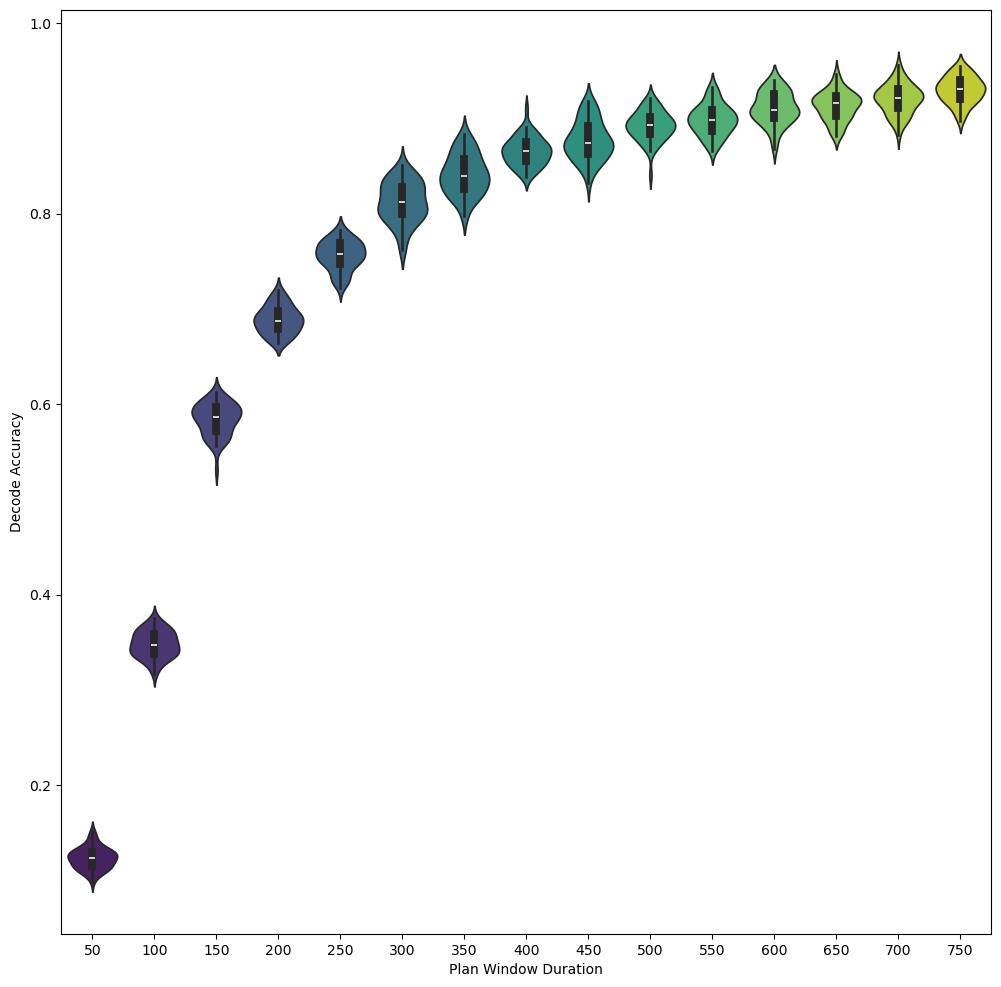

In [17]:
fig = plt.figure(figsize=(12,12))
ax = sns.violinplot(data=pd.DataFrame(decode_perf.T, 
                              columns=np.arange(50,800,50)),
                              palette="viridis")
ax.set(xlabel='Plan Window Duration', ylabel='Decode Accuracy')


# Problem 1C (20 pts) - Where should the plan window begin?

As discussed in class, the time when the brain actually begins planning is some moments after when the target appears. You will use decoding to identify this moment. To be able to see a big difference, use a small window size, and make sure that the sum of the `start_offset` and the `window_length` parameters is less than 750 (to make sure all windows are valid both for long and short trials). You can use a very similar loop to the one above, except now, you make the outer loop loop over the `start_offset` parameter: 

```
decode_perf = [] # this will be a list of lists - outer list is different plan window starts, inner list is statistical repititions
for start_offset in np.arange(0,525,25): # (with a window length of 250, this will go to 750!!!)
    plan_spikes = extract_plan_spikes(window_length=250, start_offset=start_offset)

    ... # other code you'll potentially need to modify???

```

Plot the results - based on decode performance, when do you think the window of neural planning actually starts? (If you want, you can modify the `np.arange` line in the code to give higher temporal resolution, or modify the window_length.)

In [18]:

decode_perf = [] # this will be a list of lists - outer list is different plan window sizes, inner list is statistical repititions
for start_offset in np.arange(0,525,25): # (this goes to 750!!!)
    plan_spikes = extract_plan_spikes(window_length=250, start_offset=start_offset)

    decode_perf.append([])
    
    # Randomly choose training and test data 25 times
    for i in range(50): 
        
        test_trials = [] # all the leftovers
        training_trials = [] # will be 8 lists of trial indices (one list per direction)
        target_trials = []

        for c in range(8): # reach targets go from 0 to 7
            # get the indices of the trials for each target
            target_trials.append(np.argwhere((trial_reach_target==c)).squeeze())
        
        for c in range(8): # reach targets go from 0 to 7
            # randomly select 25 training trials per direction
            random_training_trials = np.random.choice(target_trials[c], 25, replace=False) # numpy helper that picks a random subset of samples
            training_trials.append(random_training_trials)
            remaining_test_trials = np.setdiff1d(target_trials[c], random_training_trials) # which ones are left?
            
            test_trials.extend(remaining_test_trials) # we use "extend" to make one long list of test trials, which will include all targets
        
        mean_spike_counts = np.zeros((num_neurons, 8))
        #### Fill in the calculation of the mean_spike_counts for each target here
        for c in range(8):
            mean_spike_counts[:,c] = np.mean(plan_spikes[:, training_trials[c]], axis=1)

        poisson_likelihood = np.zeros((len(test_trials), 8))    
        #### Fill in the calculation of the Poisson log likelihoods here
        for c in range(8):
            m = mean_spike_counts[:,c]
            poisson_likelihood[:,c] = \
                multivariate_poisson_logpdf(m, plan_spikes[:, test_trials])
        
        correct_targets = trial_reach_target[test_trials] # correct target for each trial
        decoded_targets = np.argmax(poisson_likelihood,axis=1) # decoded target is just the max index
        decode_perf[-1].append(np.mean(correct_targets==decoded_targets))

decode_perf = np.array(decode_perf) # convert to a numpy array

[Text(0.5, 0, 'Plan Window Duration'), Text(0, 0.5, 'Decode Accuracy')]

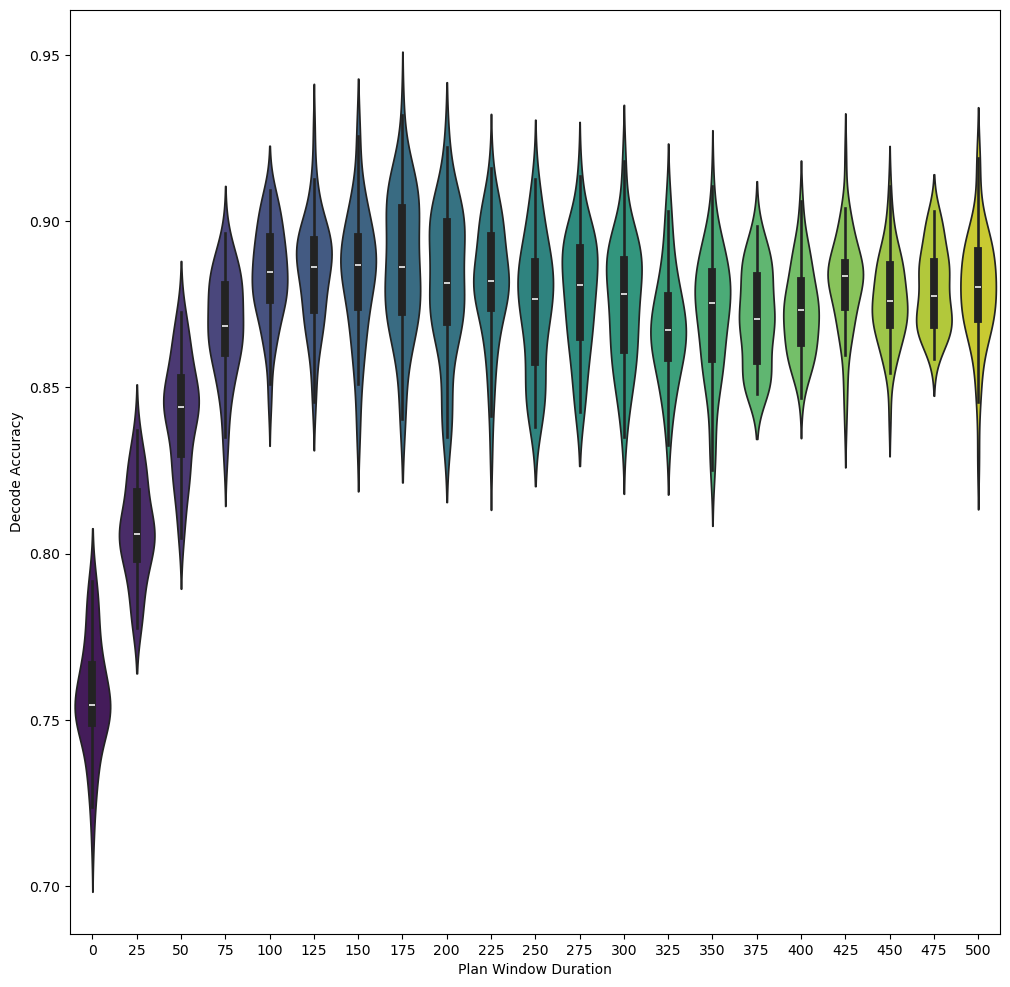

In [19]:
fig = plt.figure(figsize=(12,12))
ax = sns.violinplot(data=pd.DataFrame(decode_perf.T, 
                              columns=np.arange(0,525,25)),
                              palette="viridis")
ax.set(xlabel='Plan Window Duration', ylabel='Decode Accuracy')

# Problem 2A (30 pts) - How does the number of neurons affect performance?

Now modify the code from 1B to randomly select neural ensembles in addition to training and test trials. You should use a 250 ms plan window with a 100 ms offset. Evaluate average decoding performance as a function of the number of neurons used by the decoder. Specifically, repeatedly (at least 25 times) randomly sample groups of neurons of size 30, 60, 90, 120, and 150, and calculate average decode performance. About how many neurons do you need for good performance?

Hints on code to modify. If the indices of your random neurons are in neuron_idx, you need to change the code that calculates the mean spike counts:

```
    num_neurons = len(neuron_idx) 
    mean_spike_counts = np.zeros((num_neurons, 8))
    for c in range(8):
        mean_spike_counts[:,c] = np.mean(plan_spikes[training_trials[c], neuron_idx], axis=0)
```

Furthemore, you’ll need to change the code that calculates the likelihood:
```
    poisson_likelihood[:,c] =
        multivariate_poisson_logpdf(m, plan_spikes[test_trials, neuron_idx])
```

To get random indices of neurons, you can use the `numpy.random.choice` function in a similar way to how the train trials are selected.
```
    neuron_idx = np.random.choice(range(190), NUMBER_OF_NEURONS, replace=False)
```

In particular, the “replace=False” instruction is important. Without it, the default is to potentially give multiple copies of the same value. 190 here is the total number of values you want to randomly sample from - there are 190 neurons in the dataset. (And `NUMBER_OF_NEURONS` would be replaced with the name of the variable that your outer loop is generating.)


In [20]:

decode_perf = [] # this will be a list of lists - outer list is different plan window sizes, inner list is statistical repititions
for NUMBER_OF_NEURONS in [30, 60, 90, 120, 150]: # (this goes to 750!!!)
    plan_spikes = extract_plan_spikes(window_length=250, start_offset=100)

    decode_perf.append([])
    
    # Randomly choose training and test data 25 times
    for i in range(50): 
        
        test_trials = [] # all the leftovers
        training_trials = [] # will be 8 lists of trial indices (one list per direction)
        target_trials = []

        for c in range(8): # reach targets go from 0 to 7
            # get the indices of the trials for each target
            target_trials.append(np.argwhere((trial_reach_target==c)).squeeze())
        
        for c in range(8): # reach targets go from 0 to 7
            # randomly select 25 training trials per direction
            random_training_trials = np.random.choice(target_trials[c], 25, replace=False) # numpy helper that picks a random subset of samples
            training_trials.append(random_training_trials)
            remaining_test_trials = np.setdiff1d(target_trials[c], random_training_trials) # which ones are left?
            
            test_trials.extend(remaining_test_trials) # we use "extend" to make one long list of test trials, which will include all targets
        
        neuron_idx = np.random.choice(range(190), NUMBER_OF_NEURONS, replace=False)
        
        mean_spike_counts = np.zeros((NUMBER_OF_NEURONS, 8))
        for c in range(8):
            mean_spike_counts[:,c] = np.mean(plan_spikes[neuron_idx][:,training_trials[c]], axis=1)

        poisson_likelihood = np.zeros((len(test_trials), 8))    
        #### Fill in the calculation of the Poisson log likelihoods here
        for c in range(8):
            m = mean_spike_counts[:,c]
            poisson_likelihood[:,c] = \
                multivariate_poisson_logpdf(m, plan_spikes[neuron_idx][:,test_trials])
                    
        correct_targets = trial_reach_target[test_trials] # correct target for each trial
        decoded_targets = np.argmax(poisson_likelihood,axis=1) # decoded target is just the max index
        decode_perf[-1].append(np.mean(correct_targets==decoded_targets))

decode_perf = np.array(decode_perf) # convert to a numpy array

[Text(0.5, 0, 'Plan Window Duration'), Text(0, 0.5, 'Decode Accuracy')]

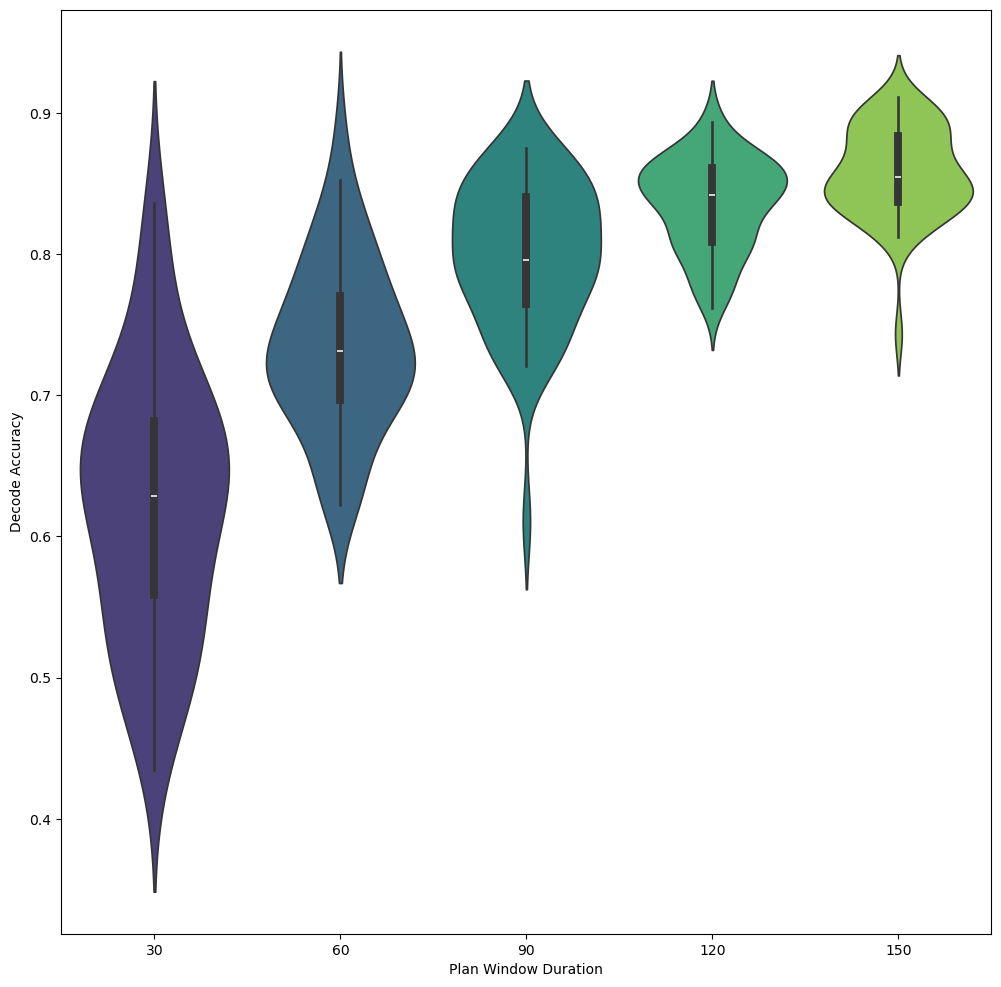

In [21]:
fig = plt.figure(figsize=(12,12))
ax = sns.violinplot(data=pd.DataFrame(decode_perf.T, 
                              columns=[30, 60, 90, 120, 150]),
                              palette="viridis")
ax.set(xlabel='Plan Window Duration', ylabel='Decode Accuracy')

# Problem 2B (20 pts) - How does firing rate change performance?

Using the `mean_spike_counts` calculated for the whole ensemble, find the 30 neurons with the average highest firing rates (averaged over all directions), and the 30 neurons with the lowest average firing rates. The function `numpy.argsort` will help you here by giving you sorted indices - you can pick the first 30 outputs or the last 30. How does the decode performance of these two cherry picked ensembles compare with average performance from randomly selected neurons?

In [22]:
def findSpecificNeurons(neuron_idx):
    '''
        This function takes in a list of neuron indices and returns the decode performance 
        for each of them
    '''
    decode_perf = [] # this will be a list of lists - outer list is different plan window sizes, inner list is statistical repititions
    plan_spikes = extract_plan_spikes(window_length=250, start_offset=100)
    decode_perf.append([])

    # Randomly choose training and test data 25 times
    for i in range(50): 
        
        test_trials = [] # all the leftovers
        training_trials = [] # will be 8 lists of trial indices (one list per direction)
        target_trials = []

        for c in range(8): # reach targets go from 0 to 7
            # get the indices of the trials for each target
            target_trials.append(np.argwhere((trial_reach_target==c)).squeeze())
        
        for c in range(8): # reach targets go from 0 to 7
            # randomly select 25 training trials per direction
            random_training_trials = np.random.choice(target_trials[c], 25, replace=False) # numpy helper that picks a random subset of samples
            training_trials.append(random_training_trials)
            remaining_test_trials = np.setdiff1d(target_trials[c], random_training_trials) # which ones are left?
            
            test_trials.extend(remaining_test_trials) # we use "extend" to make one long list of test trials, which will include all targets
        
        
        mean_spike_counts = np.zeros((len(neuron_idx), 8))
        for c in range(8):
            mean_spike_counts[:,c] = np.mean(plan_spikes[neuron_idx][:,training_trials[c]], axis=1)

        poisson_likelihood = np.zeros((len(test_trials), 8))    
        #### Fill in the calculation of the Poisson log likelihoods here
        for c in range(8):
            m = mean_spike_counts[:,c]
            poisson_likelihood[:,c] = \
                multivariate_poisson_logpdf(m, plan_spikes[neuron_idx][:,test_trials])
                    
        correct_targets = trial_reach_target[test_trials] # correct target for each trial
        decoded_targets = np.argmax(poisson_likelihood,axis=1) # decoded target is just the max index
        decode_perf[-1].append(np.mean(correct_targets==decoded_targets))

    return np.array(decode_perf) # convert to a numpy array

[Text(0.5, 0, 'Neurons Present'), Text(0, 0.5, 'Decode Accuracy')]

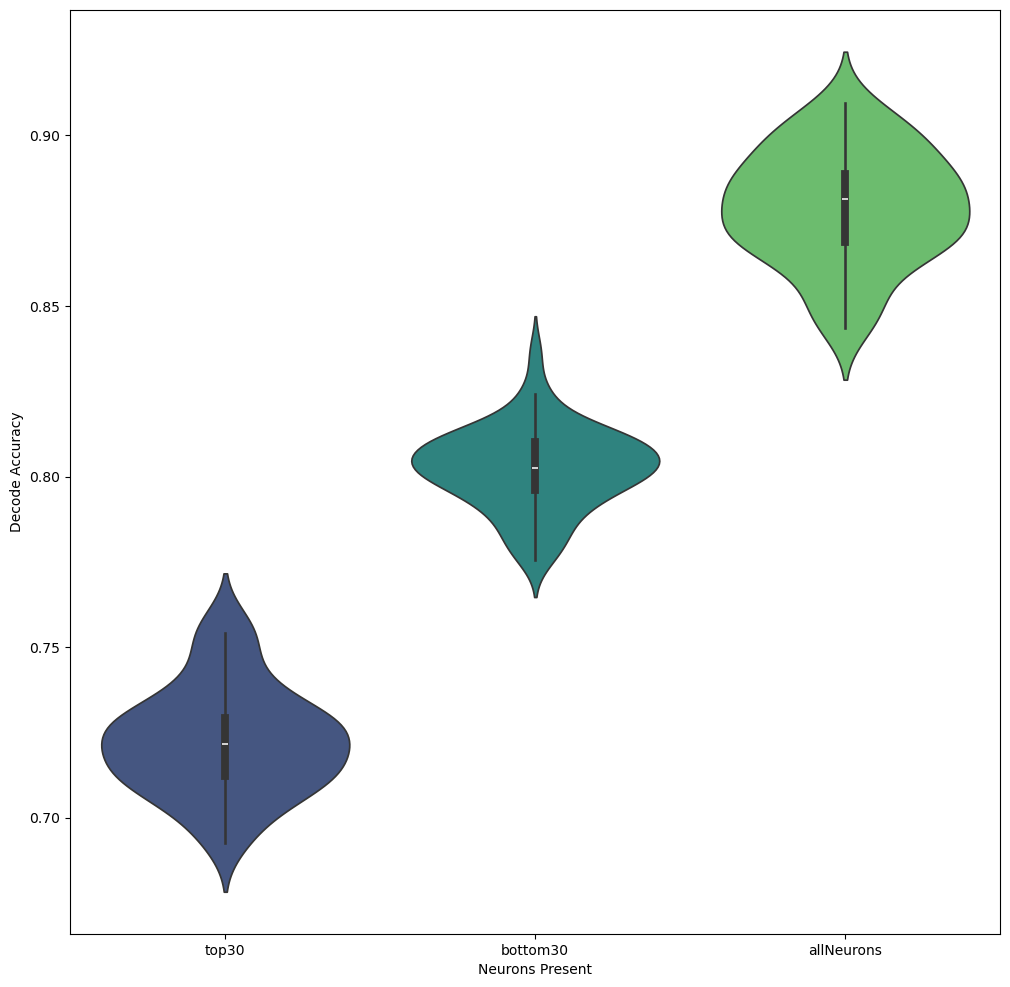

In [23]:
allmean = np.mean(mean_spike_counts, axis=1)
# get indices of highest mean spike counts
idx = np.argsort(allmean)
# get the top and bottom 30 neurons
top = idx[-30:]
bottom = idx[:30]

tt = findSpecificNeurons(top)
bt = findSpecificNeurons(bottom)
allNeuron = findSpecificNeurons(range(190))

decode_perf = np.squeeze(np.array([tt, bt, allNeuron])) # convert to a numpy array

fig = plt.figure(figsize=(12,12))
ax = sns.violinplot(data=pd.DataFrame(decode_perf.T, 
                              columns=['top30', 'bottom30', 'allNeurons']),
                              palette="viridis")
ax.set(xlabel='Neurons Present', ylabel='Decode Accuracy')

# Problem 2C (20 pts extra credit). What is the minimum size of ensemble that will yield good performance? 

Can you identify a set of neurons that will achieve the average ensemble performance for 50 neurons? 100 neurons? 150 neurons? What is the minimum size ensemble needed for these?

In [24]:
allmean = np.mean(mean_spike_counts, axis=1)
# get indices of highest mean spike counts
sortedspikes = np.argsort(allmean)

random50 = np.random.choice(range(190), 50, replace=False)
r50 = findSpecificNeurons(random50)
random100 = np.random.choice(range(190), 100, replace=False)
r100 = findSpecificNeurons(random100)
random150 = np.random.choice(range(190), 150, replace=False)
r150 = findSpecificNeurons(random150)

[Text(0.5, 0, 'Number of Neurons'), Text(0, 0.5, 'Decode Accuracy')]

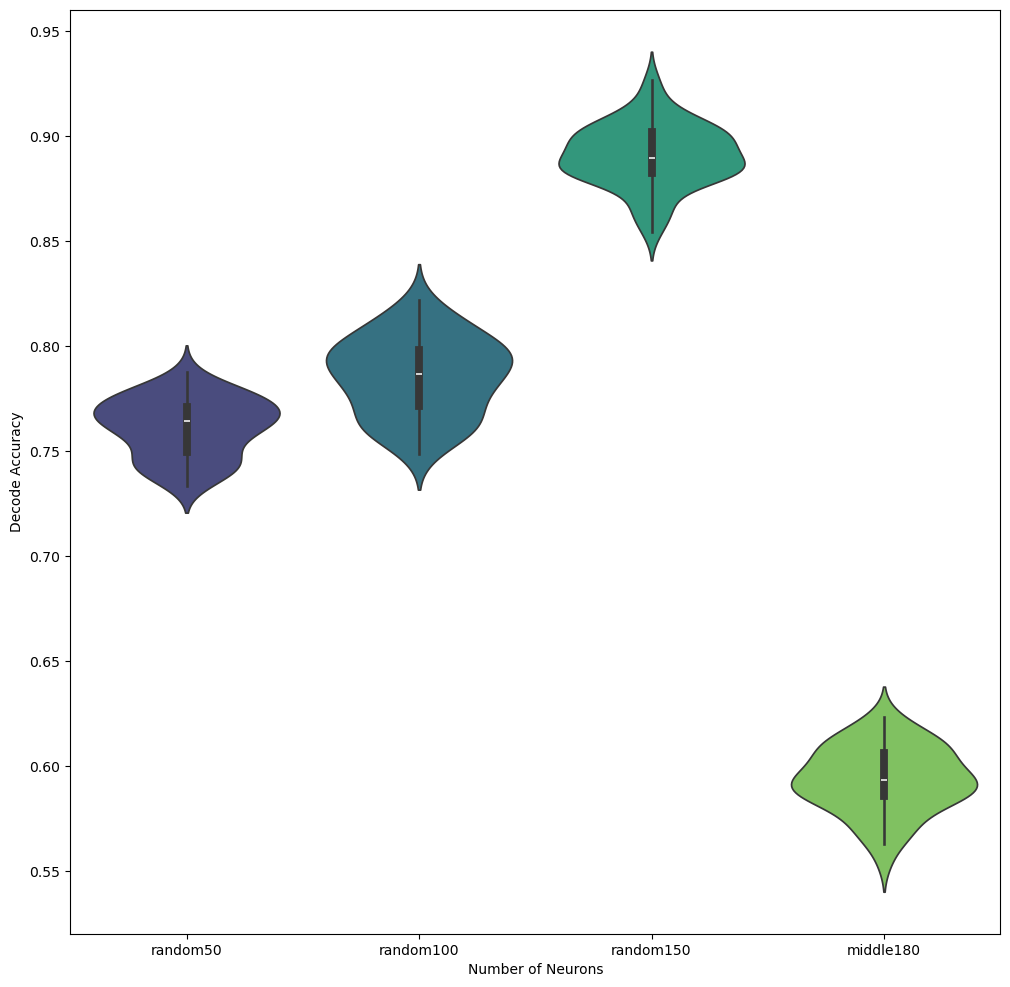

In [25]:
mNum = 180; # number of neurons in the middle
sNum = len(sortedspikes) # number of neurons
middle = sortedspikes[int(sNum/2-mNum/2) : int(sNum/2+mNum/2)]
m10 = findSpecificNeurons(middle)

decode_perf = np.squeeze(np.array([r50, r100, r150, m10])) # convert to a numpy array
fig = plt.figure(figsize=(12,12))
ax = sns.violinplot(data=pd.DataFrame(decode_perf.T, 
                              columns=['random50', 'random100', 'random150', 'middle'+str(mNum)]),
                              palette="viridis")
ax.set(xlabel='Number of Neurons', ylabel='Decode Accuracy')

Based upon the data shown above, it looks like you need the middle 32 neurons in order to math the decoding performance of a random set of 50 neurons. This is 64% of the total neurosn necessary to match the performance of a random set of 50 neurons

You need the middle 70 neurons to match the decoding performance of a random set of 100 neurons. This is 70% of the total neurosn necessary to match the performance of a random set of 50 neurons

You would need essentially every neuron in order to match the decoding performance of a random set of 150 neurons.

It seems like as the number of random neurons increases, it becomes harder and harder to match the level of randomness required to decode a random set of neurons extremely accuracy. At a certain point, it becomes better to look at a random set of neurons rather than a specific set that "should" match the accuracy.

# Problem 3 (20 pts extra credit)

Modify the notebook from problem 1 to test the effect of changing the size of the training data set using a 250 ms duration plan window starting after a 100 ms ofset. How does decode performance compare for training sets of size 5, 10, 15, 20, 25, 30, 35, and 40?


[Text(0.5, 0, 'Training Set Size'), Text(0, 0.5, 'Decode Accuracy')]

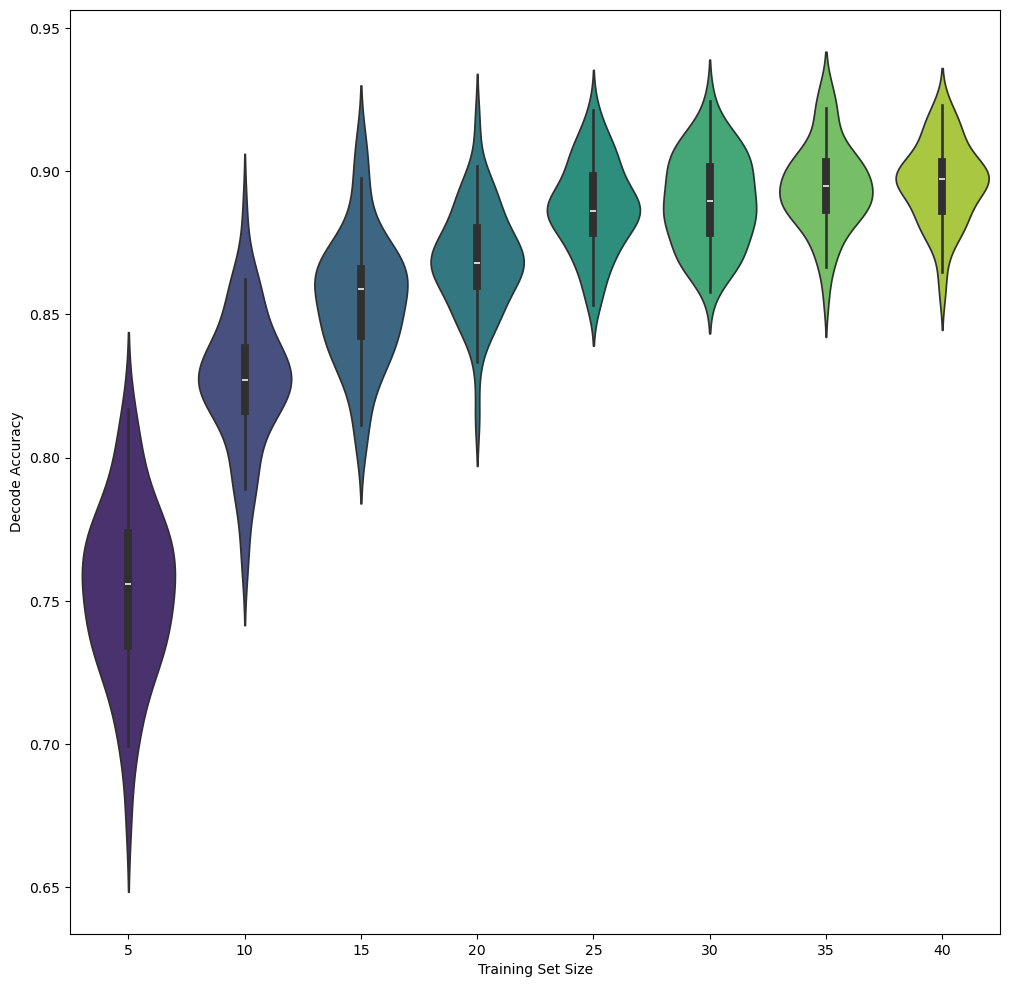

In [26]:

decode_perf = [] # this will be a list of lists - outer list is different plan window sizes, inner list is statistical repititions
NUMBER_OF_NEURONS = 190
plan_spikes = extract_plan_spikes(window_length=250, start_offset=100)

for trialnum in np.arange(5,45,5): # (this goes to 750!!!)

    decode_perf.append([])
    
    # Randomly choose training and test data 25 times
    for i in range(50): 
        
        test_trials = [] # all the leftovers
        training_trials = [] # will be 8 lists of trial indices (one list per direction)
        target_trials = []

        for c in range(8): # reach targets go from 0 to 7
            # get the indices of the trials for each target
            target_trials.append(np.argwhere((trial_reach_target==c)).squeeze())
        
        for c in range(8): # reach targets go from 0 to 7
            # randomly select 25 training trials per direction
            random_training_trials = np.random.choice(target_trials[c], trialnum, replace=False) # numpy helper that picks a random subset of samples
            training_trials.append(random_training_trials)
            remaining_test_trials = np.setdiff1d(target_trials[c], random_training_trials) # which ones are left?
            
            test_trials.extend(remaining_test_trials) # we use "extend" to make one long list of test trials, which will include all targets
        
        neuron_idx = np.random.choice(range(190), NUMBER_OF_NEURONS, replace=False)
        
        mean_spike_counts = np.zeros((NUMBER_OF_NEURONS, 8))
        for c in range(8):
            mean_spike_counts[:,c] = np.mean(plan_spikes[neuron_idx][:,training_trials[c]], axis=1)

        poisson_likelihood = np.zeros((len(test_trials), 8))    
        #### Fill in the calculation of the Poisson log likelihoods here
        for c in range(8):
            m = mean_spike_counts[:,c]
            poisson_likelihood[:,c] = \
                multivariate_poisson_logpdf(m, plan_spikes[neuron_idx][:,test_trials])
                    
        correct_targets = trial_reach_target[test_trials] # correct target for each trial
        decoded_targets = np.argmax(poisson_likelihood,axis=1) # decoded target is just the max index
        decode_perf[-1].append(np.mean(correct_targets==decoded_targets))

decode_perf = np.array(decode_perf) # convert to a numpy array

fig = plt.figure(figsize=(12,12))
ax = sns.violinplot(data=pd.DataFrame(decode_perf.T, 
                              columns=np.arange(5,45,5)),
                              palette="viridis")
ax.set(xlabel='Training Set Size', ylabel='Decode Accuracy')

Decoding performance improves as the size of the training set increases, following a logarithmic trend. This improvement is due to the additional information available to the model, which enhances its ability to learn and make accurate predictions.